In [1]:
IRT_DIMS = 1
TEST = True

In [2]:
import sys, os, shutil
import pickle
import time
import numpy as np
from utils import (mymode, load_data_heterogeneous, create_data_object_heterogeneous)
import seaborn as sns

from IRT import MIRT_2PL
from Heterogeneous_embedder import EmbedderHeterogeneous, train_embedder_heterogeneous, test_embedder_heterogeneous
from manage_experiments import perform_cross_validation

import torch
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

MAXES = 10
MINEPOCHS = 5

In [3]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# Initialise
parameters = {
    'df_name': None,
    'epochs': 10000,
    'learning_rate': 0.005,
    'weight_decay': 0,
    'early_stopping': 200,
    'n_splits': 10,
    'device': 'cuda:0',
    'batch_size': 1024
    }

if IRT_DIMS > 0:
    parameters['model_type'] = 'IRT'
    parameters['hidden_dims'] = IRT_DIMS
    parameters['lambda1'] = 0.0001
    parameters['lambda2'] = 0.0001
    OUTNAME = 'IRT'
else:
    parameters['model_type'] = 'GNN'
    parameters['hidden_dims'] = [16,8]
    OUTNAME = 'SAGE' 

In [5]:
if TEST: 
    #DATA_FILE = 'data/mindsteps_set_matrix_20000'    
    DATA_FILE = 'data/mindsteps_set_test_matrix'    
else:
    DATA_FILE = 'data/mindsteps_set_full' 

In [6]:
df = load_data_heterogeneous(DATA_FILE)
data, df_student, df_item, df_edge = create_data_object_heterogeneous(df, return_aux_data=True)

(327841, 24)


In [7]:
df.columns

Index(['studentId', 'code', 'motherTongue', 'Gender', 'scale', 'matrix',
       'IRT_difficulty', 'topic', 'responseformat', 'textlength', 'score',
       'age', 'grade', 'viewingTime', 'timestamp', 'useCase', 'assessmentId',
       'ability', 'frequency', 'previous_sessions', 'years_from_start',
       'matdiff', 'matcode', 'domain'],
      dtype='object')

In [8]:
df.head()

,studentId,code,motherTongue,Gender,scale,matrix,IRT_difficulty,topic,responseformat,textlength,...,timestamp,useCase,assessmentId,ability,frequency,previous_sessions,years_from_start,matdiff,matcode,domain
0,0,0,0.0,0.0,dles,D.2.B.1.f,0.268748,Zeitungsartikel,NaN,NaN,...,7.643058e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
1,0,1,0.0,0.0,dles,D.2.B.1.h,1.217388,Textsorten erkennen,single choice,NaN,...,7.643061e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d
2,0,2,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.845624e-312,ms-kber,E109B3CDD31EDCFE7F48665587372C60A3FAEBB8571544...,2.421279,4.137915,6,1.45,,,d
3,0,3,0.0,0.0,dles,D.2.B.1.h,1.584145,Wissenstexte: Mix,single choice,NaN,...,7.851631e-312,ms-kber,319A0FE3AFDC0A30C4C1B26577B5B19FE66E918A181354...,2.174872,7.432378,11,1.48,,,d
4,0,4,0.0,0.0,dles,D.2.C.1.h,1.172410,Geschichten lang,single choice,NaN,...,7.643059e-312,ms-kber,5E9436B294DBE2FB740ADDCF2B883ECB2254B5F0D37D8E...,2.667269,13.333162,2,0.15,,,d


edge_dim = data['student', 'responds', 'item'].edge_attr.shape[1]
if IRT_DIMS > 0:
    model = MIRT_2PL(IRT_DIMS, edge_dim, data)
else:
    model = EmbedderHeterogeneous( 
        n_students =  data['student'].x.size(0),
        n_items = data['item'].x.size(0),
        student_inchannel = data['student'].x.size(1),
        item_inchannel = data['item'].x.size(1),
        hidden_channels=parameters['hidden_dims'],
        edge_channel=edge_dim,
        metadata=data.metadata()
        ).to(device)
    
model = model.to(device)

In [9]:
output_dict, model = perform_cross_validation(data, parameters, save_embeddings=True, save_subgraph=True, final_fit=True)

0it [00:00, ?it/s]
  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  3.11it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.61it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.52it/s]

100%|██████████| 4/4 [00:00<00:00,  5.55it/s]



Epoch: 001, Loss: 30452.2598, Val: 0.5044, Test: 0.4983



  0%|          | 1/10000 [00:01<3:03:19,  1.10s/it]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.56it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.05it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.82it/s]

100%|██████████| 4/4 [00:00<00:00,  8.26it/s]

  0%|          | 2/10000 [00:01<2:21:48,  1.18it/s]


Epoch: 002, Loss: 29666.1504, Val: 0.5058, Test: 0.4989




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.73it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.99it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.04it/s]

100%|██████████| 4/4 [00:00<00:00,  5.94it/s]

  0%|          | 3/10000 [00:02<2:32:03,  1.10it/s]


Epoch: 003, Loss: 28678.4609, Val: 0.5074, Test: 0.5005




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.10it/s]

100%|██████████| 4/4 [00:00<00:00,  9.70it/s]



Epoch: 004, Loss: 27954.9121, Val: 0.5098, Test: 0.5016



  0%|          | 4/10000 [00:03<2:21:39,  1.18it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.27it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.19it/s]

100%|██████████| 4/4 [00:00<00:00,  7.74it/s]

  0%|          | 5/10000 [00:04<2:07:44,  1.30it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.57it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.22it/s]

100%|██████████| 4/4 [00:00<00:00,  8.98it/s]



Epoch: 006, Loss: 26808.6309, Val: 0.5126, Test: 0.5040



  0%|          | 6/10000 [00:04<2:05:38,  1.33it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.44it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.88it/s]

100%|██████████| 4/4 [00:00<00:00,  7.90it/s]

  0%|          | 7/10000 [00:05<2:00:51,  1.38it/s]


Epoch: 007, Loss: 26156.1641, Val: 0.5141, Test: 0.5065




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.62it/s]

100%|██████████| 4/4 [00:00<00:00, 12.20it/s]

  0%|          | 8/10000 [00:06<1:57:39,  1.42it/s]


Epoch: 008, Loss: 25573.1699, Val: 0.5157, Test: 0.5090




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.05it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.96it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.80it/s]

100%|██████████| 4/4 [00:00<00:00,  7.29it/s]



Epoch: 009, Loss: 24503.5801, Val: 0.5178, Test: 0.5102



  0%|          | 9/10000 [00:07<2:10:37,  1.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.02it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.57it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.19it/s]

100%|██████████| 4/4 [00:00<00:00,  6.41it/s]

  0%|          | 10/10000 [00:07<2:12:20,  1.26it/s]


Epoch: 010, Loss: 24058.3574, Val: 0.5191, Test: 0.5124




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.34it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.50it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.22it/s]

100%|██████████| 4/4 [00:00<00:00,  7.32it/s]

  0%|          | 11/10000 [00:08<2:16:58,  1.22it/s]


Epoch: 011, Loss: 23227.6465, Val: 0.5208, Test: 0.5143




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.78it/s]

100%|██████████| 4/4 [00:00<00:00, 11.53it/s]



Epoch: 012, Loss: 22808.0996, Val: 0.5231, Test: 0.5159



  0%|          | 12/10000 [00:09<2:09:01,  1.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.54it/s]

100%|██████████| 4/4 [00:00<00:00, 12.01it/s]

  0%|          | 13/10000 [00:09<1:52:58,  1.47it/s]


Epoch: 013, Loss: 23095.1621, Val: 0.5252, Test: 0.5176




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.85it/s]

100%|██████████| 4/4 [00:00<00:00, 11.81it/s]

  0%|          | 14/10000 [00:10<1:52:57,  1.47it/s]


Epoch: 014, Loss: 22088.5898, Val: 0.5260, Test: 0.5199




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.42it/s]

100%|██████████| 4/4 [00:00<00:00, 12.00it/s]



Epoch: 015, Loss: 21480.6504, Val: 0.5277, Test: 0.5215



  0%|          | 15/10000 [00:11<1:52:10,  1.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.18it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.67it/s]

100%|██████████| 4/4 [00:00<00:00,  7.44it/s]



Epoch: 016, Loss: 21032.8418, Val: 0.5299, Test: 0.5241



  0%|          | 16/10000 [00:12<2:01:42,  1.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.18it/s]

100%|██████████| 4/4 [00:00<00:00, 10.69it/s]

  0%|          | 17/10000 [00:12<1:51:42,  1.49it/s]


Epoch: 017, Loss: 20472.3887, Val: 0.5318, Test: 0.5251




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.26it/s]

100%|██████████| 4/4 [00:00<00:00, 11.77it/s]

  0%|          | 18/10000 [00:13<1:48:43,  1.53it/s]


Epoch: 018, Loss: 20061.9277, Val: 0.5331, Test: 0.5263




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.96it/s]

100%|██████████| 4/4 [00:00<00:00, 10.85it/s]



Epoch: 019, Loss: 19349.0312, Val: 0.5358, Test: 0.5279



  0%|          | 19/10000 [00:14<1:49:30,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.22it/s]

100%|██████████| 4/4 [00:00<00:00, 12.78it/s]

  0%|          | 20/10000 [00:14<1:39:27,  1.67it/s]


Epoch: 020, Loss: 18850.3457, Val: 0.5366, Test: 0.5300




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.31it/s]

100%|██████████| 4/4 [00:00<00:00, 11.68it/s]

  0%|          | 21/10000 [00:15<1:41:30,  1.64it/s]


Epoch: 021, Loss: 18784.1172, Val: 0.5380, Test: 0.5315




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.82it/s]

100%|██████████| 4/4 [00:00<00:00, 11.63it/s]



Epoch: 022, Loss: 18199.3691, Val: 0.5413, Test: 0.5327



  0%|          | 22/10000 [00:15<1:45:08,  1.58it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.95it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.07it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.10it/s]

100%|██████████| 4/4 [00:00<00:00,  7.51it/s]

  0%|          | 23/10000 [00:16<1:49:02,  1.53it/s]


Epoch: 023, Loss: 17656.3828, Val: 0.5424, Test: 0.5337




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.70it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.61it/s]

100%|██████████| 4/4 [00:00<00:00,  7.00it/s]

  0%|          | 24/10000 [00:17<2:03:16,  1.35it/s]


Epoch: 024, Loss: 17061.4121, Val: 0.5440, Test: 0.5359




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.72it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.26it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.10it/s]

100%|██████████| 4/4 [00:00<00:00,  7.42it/s]



Epoch: 025, Loss: 17115.9023, Val: 0.5453, Test: 0.5377



  0%|          | 25/10000 [00:18<2:10:24,  1.27it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.88it/s]

100%|██████████| 4/4 [00:00<00:00, 10.69it/s]

  0%|          | 26/10000 [00:18<1:58:54,  1.40it/s]


Epoch: 026, Loss: 16446.7969, Val: 0.5467, Test: 0.5402




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.23it/s]

100%|██████████| 4/4 [00:00<00:00,  9.63it/s]

  0%|          | 27/10000 [00:19<1:59:55,  1.39it/s]


Epoch: 027, Loss: 16023.5273, Val: 0.5483, Test: 0.5410




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.62it/s]

100%|██████████| 4/4 [00:00<00:00,  9.98it/s]



Epoch: 028, Loss: 15614.2188, Val: 0.5489, Test: 0.5426



  0%|          | 28/10000 [00:20<1:59:35,  1.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.22it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.01it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.49it/s]

100%|██████████| 4/4 [00:00<00:00,  6.99it/s]



Epoch: 029, Loss: 15243.4258, Val: 0.5517, Test: 0.5445



  0%|          | 29/10000 [00:21<2:10:02,  1.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.94it/s]

100%|██████████| 4/4 [00:00<00:00, 12.99it/s]

  0%|          | 30/10000 [00:21<1:52:35,  1.48it/s]


Epoch: 030, Loss: 15270.8721, Val: 0.5534, Test: 0.5460




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.40it/s]

100%|██████████| 4/4 [00:00<00:00, 13.41it/s]

  0%|          | 31/10000 [00:22<1:49:42,  1.51it/s]


Epoch: 031, Loss: 14495.1816, Val: 0.5561, Test: 0.5469




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.21it/s]

100%|██████████| 4/4 [00:00<00:00, 13.15it/s]



Epoch: 032, Loss: 14281.6279, Val: 0.5591, Test: 0.5481



  0%|          | 32/10000 [00:22<1:47:11,  1.55it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.52it/s]

100%|██████████| 4/4 [00:00<00:00,  9.23it/s]

  0%|          | 33/10000 [00:23<1:44:47,  1.59it/s]


Epoch: 033, Loss: 13815.2988, Val: 0.5604, Test: 0.5508




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.91it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.73it/s]

100%|██████████| 4/4 [00:00<00:00,  8.81it/s]

  0%|          | 34/10000 [00:24<1:50:13,  1.51it/s]


Epoch: 034, Loss: 13719.0410, Val: 0.5613, Test: 0.5523




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.01it/s]

100%|██████████| 4/4 [00:00<00:00, 10.44it/s]



Epoch: 035, Loss: 13323.7842, Val: 0.5629, Test: 0.5548



  0%|          | 35/10000 [00:25<1:55:43,  1.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.48it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.41it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.25it/s]

100%|██████████| 4/4 [00:00<00:00,  5.89it/s]

  0%|          | 36/10000 [00:25<2:03:54,  1.34it/s]


Epoch: 036, Loss: 13327.9521, Val: 0.5636, Test: 0.5570




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.94it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.75it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.85it/s]

100%|██████████| 4/4 [00:00<00:00,  8.30it/s]

  0%|          | 37/10000 [00:26<2:07:17,  1.30it/s]


Epoch: 037, Loss: 12997.5869, Val: 0.5661, Test: 0.5597




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.83it/s]

100%|██████████| 4/4 [00:00<00:00, 10.23it/s]



Epoch: 038, Loss: 12576.9658, Val: 0.5682, Test: 0.5616



  0%|          | 38/10000 [00:27<2:03:31,  1.34it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.13it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.75it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.48it/s]

100%|██████████| 4/4 [00:00<00:00,  6.89it/s]

  0%|          | 39/10000 [00:28<2:04:49,  1.33it/s]


Epoch: 039, Loss: 12500.4424, Val: 0.5705, Test: 0.5632




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.24it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.91it/s]

100%|██████████| 4/4 [00:00<00:00,  9.36it/s]

  0%|          | 40/10000 [00:28<2:04:35,  1.33it/s]


Epoch: 040, Loss: 11725.2158, Val: 0.5719, Test: 0.5650




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.81it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.95it/s]

100%|██████████| 4/4 [00:00<00:00, 10.99it/s]



Epoch: 041, Loss: 11930.4697, Val: 0.5742, Test: 0.5673



  0%|          | 41/10000 [00:29<1:59:32,  1.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.61it/s]

100%|██████████| 4/4 [00:00<00:00,  9.69it/s]



Epoch: 042, Loss: 11506.9902, Val: 0.5760, Test: 0.5692



  0%|          | 42/10000 [00:30<2:00:32,  1.38it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.86it/s]

100%|██████████| 4/4 [00:00<00:00, 10.36it/s]

  0%|          | 43/10000 [00:30<1:51:35,  1.49it/s]


Epoch: 043, Loss: 11268.3760, Val: 0.5775, Test: 0.5709




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.29it/s]

100%|██████████| 4/4 [00:00<00:00, 11.08it/s]

  0%|          | 44/10000 [00:31<1:50:20,  1.50it/s]


Epoch: 044, Loss: 11100.5029, Val: 0.5794, Test: 0.5727




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.62it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.50it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.76it/s]

100%|██████████| 4/4 [00:00<00:00,  8.13it/s]



Epoch: 045, Loss: 10753.2568, Val: 0.5817, Test: 0.5744



  0%|          | 45/10000 [00:32<1:58:38,  1.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.52it/s]

100%|██████████| 4/4 [00:00<00:00, 10.44it/s]

  0%|          | 46/10000 [00:32<1:49:24,  1.52it/s]


Epoch: 046, Loss: 10468.9980, Val: 0.5840, Test: 0.5765




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.24it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.43it/s]

100%|██████████| 4/4 [00:00<00:00,  9.34it/s]

  0%|          | 47/10000 [00:33<1:51:50,  1.48it/s]


Epoch: 047, Loss: 10438.5508, Val: 0.5852, Test: 0.5787




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.93it/s]

100%|██████████| 4/4 [00:00<00:00, 11.29it/s]



Epoch: 048, Loss: 10175.9365, Val: 0.5877, Test: 0.5805



  0%|          | 48/10000 [00:34<1:49:48,  1.51it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.41it/s]

100%|██████████| 4/4 [00:00<00:00, 10.97it/s]

  0%|          | 49/10000 [00:34<1:42:00,  1.63it/s]


Epoch: 049, Loss: 10089.2900, Val: 0.5902, Test: 0.5822




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.93it/s]

100%|██████████| 4/4 [00:00<00:00, 10.50it/s]

  0%|          | 50/10000 [00:35<1:46:05,  1.56it/s]


Epoch: 050, Loss: 9775.2783, Val: 0.5918, Test: 0.5838




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.04it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.10it/s]

100%|██████████| 4/4 [00:00<00:00,  9.03it/s]



Epoch: 051, Loss: 9627.3623, Val: 0.5946, Test: 0.5859



  1%|          | 51/10000 [00:36<1:51:24,  1.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.77it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.81it/s]

100%|██████████| 4/4 [00:00<00:00, 10.21it/s]

  1%|          | 52/10000 [00:36<1:45:29,  1.57it/s]


Epoch: 052, Loss: 9378.7012, Val: 0.5965, Test: 0.5886




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.92it/s]

100%|██████████| 4/4 [00:00<00:00, 10.59it/s]

  1%|          | 53/10000 [00:37<1:47:14,  1.55it/s]


Epoch: 053, Loss: 9228.4434, Val: 0.5975, Test: 0.5908




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.19it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.50it/s]

100%|██████████| 4/4 [00:00<00:00,  9.64it/s]



Epoch: 054, Loss: 8785.1729, Val: 0.5985, Test: 0.5926



  1%|          | 54/10000 [00:38<1:48:56,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.36it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.80it/s]

100%|██████████| 4/4 [00:00<00:00,  9.99it/s]



Epoch: 055, Loss: 8802.7070, Val: 0.6000, Test: 0.5942



  1%|          | 55/10000 [00:38<1:50:20,  1.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.10it/s]

100%|██████████| 4/4 [00:00<00:00, 11.40it/s]

  1%|          | 56/10000 [00:39<1:41:37,  1.63it/s]


Epoch: 056, Loss: 8708.5635, Val: 0.6018, Test: 0.5962




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.42it/s]

100%|██████████| 4/4 [00:00<00:00, 11.39it/s]

  1%|          | 57/10000 [00:39<1:42:39,  1.61it/s]


Epoch: 057, Loss: 8442.0996, Val: 0.6035, Test: 0.5964




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.50it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.35it/s]

100%|██████████| 4/4 [00:00<00:00, 10.01it/s]

  1%|          | 58/10000 [00:40<1:45:51,  1.57it/s]


Epoch: 058, Loss: 8359.9277, Val: 0.6039, Test: 0.5984




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.47it/s]

100%|██████████| 4/4 [00:00<00:00,  9.81it/s]

  1%|          | 59/10000 [00:41<1:41:54,  1.63it/s]


Epoch: 059, Loss: 8291.7705, Val: 0.6058, Test: 0.6001




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.72it/s]

100%|██████████| 4/4 [00:00<00:00, 11.54it/s]

  1%|          | 60/10000 [00:41<1:42:32,  1.62it/s]


Epoch: 060, Loss: 8001.3071, Val: 0.6072, Test: 0.6020




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.12it/s]

100%|██████████| 4/4 [00:00<00:00, 10.67it/s]



Epoch: 061, Loss: 7702.7031, Val: 0.6095, Test: 0.6030



  1%|          | 61/10000 [00:42<1:45:18,  1.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.63it/s]

100%|██████████| 4/4 [00:00<00:00, 10.73it/s]

  1%|          | 62/10000 [00:42<1:38:52,  1.68it/s]


Epoch: 062, Loss: 7461.0420, Val: 0.6104, Test: 0.6039




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.94it/s]

100%|██████████| 4/4 [00:00<00:00, 10.78it/s]

  1%|          | 63/10000 [00:43<1:42:10,  1.62it/s]


Epoch: 063, Loss: 7629.2983, Val: 0.6114, Test: 0.6058




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.56it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.37it/s]

100%|██████████| 4/4 [00:00<00:00, 10.45it/s]



Epoch: 064, Loss: 7503.3467, Val: 0.6123, Test: 0.6063



  1%|          | 64/10000 [00:44<1:46:20,  1.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.97it/s]

100%|██████████| 4/4 [00:00<00:00, 10.70it/s]

  1%|          | 65/10000 [00:44<1:40:03,  1.65it/s]


Epoch: 065, Loss: 7260.3442, Val: 0.6138, Test: 0.6071




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.05it/s]

100%|██████████| 4/4 [00:00<00:00, 10.61it/s]

  1%|          | 66/10000 [00:45<1:45:03,  1.58it/s]


Epoch: 066, Loss: 6996.2563, Val: 0.6160, Test: 0.6087




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.99it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.39it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.28it/s]

100%|██████████| 4/4 [00:00<00:00,  9.21it/s]



Epoch: 067, Loss: 7052.0181, Val: 0.6169, Test: 0.6100



  1%|          | 67/10000 [00:46<1:52:06,  1.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.28it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.42it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.21it/s]

100%|██████████| 4/4 [00:00<00:00,  5.58it/s]



Epoch: 068, Loss: 6900.2866, Val: 0.6189, Test: 0.6116



  1%|          | 68/10000 [00:47<2:09:24,  1.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.43it/s]

100%|██████████| 4/4 [00:00<00:00, 10.87it/s]

  1%|          | 69/10000 [00:47<1:55:17,  1.44it/s]


Epoch: 069, Loss: 6837.9771, Val: 0.6201, Test: 0.6126




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.25it/s]

100%|██████████| 4/4 [00:00<00:00, 10.45it/s]

  1%|          | 70/10000 [00:48<1:54:39,  1.44it/s]


Epoch: 070, Loss: 6564.1479, Val: 0.6207, Test: 0.6138




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.91it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.27it/s]

100%|██████████| 4/4 [00:00<00:00, 10.47it/s]



Epoch: 071, Loss: 6507.8101, Val: 0.6226, Test: 0.6153



  1%|          | 71/10000 [00:49<1:53:27,  1.46it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.70it/s]

100%|██████████| 4/4 [00:00<00:00, 10.39it/s]

  1%|          | 72/10000 [00:49<1:45:27,  1.57it/s]


Epoch: 072, Loss: 6237.7529, Val: 0.6236, Test: 0.6172




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.47it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.51it/s]

100%|██████████| 4/4 [00:00<00:00,  9.93it/s]

  1%|          | 73/10000 [00:50<1:48:38,  1.52it/s]


Epoch: 073, Loss: 6356.1650, Val: 0.6237, Test: 0.6184




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.39it/s]

100%|██████████| 4/4 [00:00<00:00, 11.34it/s]



Epoch: 074, Loss: 6253.0747, Val: 0.6257, Test: 0.6202



  1%|          | 74/10000 [00:51<1:47:30,  1.54it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.54it/s]

100%|██████████| 4/4 [00:00<00:00, 10.74it/s]

  1%|          | 75/10000 [00:51<1:39:39,  1.66it/s]


Epoch: 075, Loss: 5917.7578, Val: 0.6269, Test: 0.6214




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.98it/s]

100%|██████████| 4/4 [00:00<00:00, 10.85it/s]

  1%|          | 76/10000 [00:52<1:42:23,  1.62it/s]


Epoch: 076, Loss: 5922.6182, Val: 0.6272, Test: 0.6226




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.44it/s]

100%|██████████| 4/4 [00:00<00:00,  9.96it/s]



Epoch: 077, Loss: 5646.8276, Val: 0.6283, Test: 0.6230



  1%|          | 77/10000 [00:52<1:45:48,  1.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.80it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.16it/s]

100%|██████████| 4/4 [00:00<00:00, 10.91it/s]

  1%|          | 78/10000 [00:53<1:38:33,  1.68it/s]


Epoch: 078, Loss: 5685.0571, Val: 0.6293, Test: 0.6246




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.68it/s]

100%|██████████| 4/4 [00:00<00:00, 12.20it/s]

  1%|          | 79/10000 [00:53<1:39:26,  1.66it/s]


Epoch: 079, Loss: 5611.0498, Val: 0.6307, Test: 0.6259




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.15it/s]

100%|██████████| 4/4 [00:00<00:00, 10.19it/s]



Epoch: 080, Loss: 5673.0225, Val: 0.6326, Test: 0.6272



  1%|          | 80/10000 [00:54<1:43:18,  1.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.98it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.06it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.88it/s]

100%|██████████| 4/4 [00:00<00:00,  7.09it/s]

  1%|          | 81/10000 [00:55<1:49:17,  1.51it/s]


Epoch: 081, Loss: 5389.8423, Val: 0.6344, Test: 0.6289




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.63it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.98it/s]

100%|██████████| 4/4 [00:00<00:00,  6.53it/s]

  1%|          | 82/10000 [00:56<2:02:57,  1.34it/s]


Epoch: 082, Loss: 5276.7295, Val: 0.6360, Test: 0.6299




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.53it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.04it/s]

100%|██████████| 4/4 [00:00<00:00,  9.89it/s]

  1%|          | 83/10000 [00:56<1:59:10,  1.39it/s]


Epoch: 083, Loss: 5213.6616, Val: 0.6367, Test: 0.6313




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.48it/s]

100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

  1%|          | 84/10000 [00:57<1:53:52,  1.45it/s]


Epoch: 084, Loss: 5089.4336, Val: 0.6374, Test: 0.6319




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.47it/s]

100%|██████████| 4/4 [00:00<00:00,  9.77it/s]

  1%|          | 85/10000 [00:58<1:45:51,  1.56it/s]


Epoch: 085, Loss: 4939.8232, Val: 0.6383, Test: 0.6327




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.36it/s]

100%|██████████| 4/4 [00:00<00:00, 10.07it/s]

  1%|          | 86/10000 [00:58<1:48:16,  1.53it/s]


Epoch: 086, Loss: 4959.8604, Val: 0.6395, Test: 0.6336




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.82it/s]

100%|██████████| 4/4 [00:00<00:00, 11.39it/s]



Epoch: 087, Loss: 4942.0151, Val: 0.6397, Test: 0.6343



  1%|          | 87/10000 [00:59<1:48:44,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.23it/s]

100%|██████████| 4/4 [00:00<00:00, 10.84it/s]

  1%|          | 88/10000 [01:00<1:41:38,  1.63it/s]


Epoch: 088, Loss: 4849.2944, Val: 0.6405, Test: 0.6352




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.21it/s]

100%|██████████| 4/4 [00:00<00:00,  9.30it/s]

  1%|          | 89/10000 [01:00<1:47:48,  1.53it/s]


Epoch: 089, Loss: 4917.0981, Val: 0.6412, Test: 0.6359




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.60it/s]

100%|██████████| 4/4 [00:00<00:00,  9.69it/s]



Epoch: 090, Loss: 4612.4087, Val: 0.6419, Test: 0.6372



  1%|          | 90/10000 [01:01<1:50:36,  1.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.98it/s]

100%|██████████| 4/4 [00:00<00:00,  9.21it/s]

  1%|          | 91/10000 [01:02<1:46:17,  1.55it/s]


Epoch: 091, Loss: 4557.3252, Val: 0.6436, Test: 0.6386




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.51it/s]

100%|██████████| 4/4 [00:00<00:00, 10.18it/s]

  1%|          | 92/10000 [01:02<1:48:36,  1.52it/s]


Epoch: 092, Loss: 4539.5005, Val: 0.6443, Test: 0.6388




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.66it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.28it/s]

100%|██████████| 4/4 [00:00<00:00,  9.92it/s]



Epoch: 093, Loss: 4347.9883, Val: 0.6446, Test: 0.6401



  1%|          | 93/10000 [01:03<1:50:45,  1.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.37it/s]

100%|██████████| 4/4 [00:00<00:00,  9.99it/s]

  1%|          | 94/10000 [01:03<1:44:36,  1.58it/s]


Epoch: 094, Loss: 4230.8979, Val: 0.6458, Test: 0.6405




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.28it/s]

100%|██████████| 4/4 [00:00<00:00,  9.99it/s]

  1%|          | 95/10000 [01:04<1:46:42,  1.55it/s]


Epoch: 095, Loss: 4122.1675, Val: 0.6468, Test: 0.6413




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.58it/s]

100%|██████████| 4/4 [00:00<00:00,  9.78it/s]

  1%|          | 96/10000 [01:05<1:51:05,  1.49it/s]


Epoch: 096, Loss: 4183.7031, Val: 0.6469, Test: 0.6424




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.78it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 10.08it/s]

100%|██████████| 4/4 [00:00<00:00,  9.69it/s]



Epoch: 097, Loss: 4168.9893, Val: 0.6481, Test: 0.6427



  1%|          | 97/10000 [01:06<1:52:53,  1.46it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.20it/s]

100%|██████████| 4/4 [00:00<00:00, 11.13it/s]

  1%|          | 98/10000 [01:06<1:45:06,  1.57it/s]


Epoch: 098, Loss: 4023.0952, Val: 0.6496, Test: 0.6437




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.97it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.53it/s]

100%|██████████| 4/4 [00:00<00:00,  8.59it/s]

  1%|          | 99/10000 [01:07<1:51:43,  1.48it/s]


Epoch: 099, Loss: 3924.7051, Val: 0.6504, Test: 0.6449




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.05it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.07it/s]

100%|██████████| 4/4 [00:00<00:00, 10.05it/s]



Epoch: 100, Loss: 4001.1160, Val: 0.6508, Test: 0.6461



  1%|          | 100/10000 [01:08<1:51:39,  1.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.52it/s]

100%|██████████| 4/4 [00:00<00:00, 10.90it/s]

  1%|          | 101/10000 [01:08<1:43:18,  1.60it/s]


Epoch: 101, Loss: 3782.2703, Val: 0.6519, Test: 0.6466




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.69it/s]

100%|██████████| 4/4 [00:00<00:00, 10.56it/s]

  1%|          | 102/10000 [01:09<1:45:13,  1.57it/s]


Epoch: 102, Loss: 3884.7148, Val: 0.6528, Test: 0.6478




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.87it/s]

100%|██████████| 4/4 [00:00<00:00, 10.88it/s]



Epoch: 103, Loss: 3823.9214, Val: 0.6535, Test: 0.6481



  1%|          | 103/10000 [01:09<1:45:55,  1.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.80it/s]

100%|██████████| 4/4 [00:00<00:00, 11.46it/s]

  1%|          | 104/10000 [01:10<1:39:16,  1.66it/s]


Epoch: 104, Loss: 3593.0078, Val: 0.6540, Test: 0.6490




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.93it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.39it/s]

100%|██████████| 4/4 [00:00<00:00,  8.87it/s]

  1%|          | 105/10000 [01:11<1:42:08,  1.61it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.55it/s]

100%|██████████| 4/4 [00:00<00:00, 10.61it/s]

  1%|          | 106/10000 [01:11<1:37:01,  1.70it/s]


Epoch: 106, Loss: 3491.7395, Val: 0.6543, Test: 0.6506




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.96it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.61it/s]

100%|██████████| 4/4 [00:00<00:00, 10.14it/s]

  1%|          | 107/10000 [01:12<1:41:37,  1.62it/s]


Epoch: 107, Loss: 3487.3188, Val: 0.6547, Test: 0.6506




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.34it/s]

100%|██████████| 4/4 [00:00<00:00, 10.99it/s]



Epoch: 108, Loss: 3490.5266, Val: 0.6562, Test: 0.6510



  1%|          | 108/10000 [01:12<1:42:55,  1.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.64it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.23it/s]

100%|██████████| 4/4 [00:00<00:00,  9.64it/s]



Epoch: 109, Loss: 3463.4360, Val: 0.6577, Test: 0.6521



  1%|          | 109/10000 [01:13<1:46:53,  1.54it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.86it/s]

100%|██████████| 4/4 [00:00<00:00,  9.91it/s]

  1%|          | 110/10000 [01:14<1:40:51,  1.63it/s]


Epoch: 110, Loss: 3360.6331, Val: 0.6588, Test: 0.6532




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.46it/s]

100%|██████████| 4/4 [00:00<00:00, 12.13it/s]

  1%|          | 111/10000 [01:14<1:49:12,  1.51it/s]


Epoch: 111, Loss: 3288.7385, Val: 0.6588, Test: 0.6531




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  4.12it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.07it/s]

100%|██████████| 4/4 [00:00<00:00,  6.93it/s]



Epoch: 112, Loss: 3285.6899, Val: 0.6600, Test: 0.6539



  1%|          | 112/10000 [01:15<1:59:54,  1.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.17it/s]

100%|██████████| 4/4 [00:00<00:00, 10.15it/s]

  1%|          | 113/10000 [01:16<1:51:48,  1.47it/s]


Epoch: 113, Loss: 3221.5076, Val: 0.6605, Test: 0.6543




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.56it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.35it/s]

100%|██████████| 4/4 [00:00<00:00,  9.74it/s]

  1%|          | 114/10000 [01:17<1:52:50,  1.46it/s]


Epoch: 114, Loss: 3189.2947, Val: 0.6611, Test: 0.6553




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.19it/s]

100%|██████████| 4/4 [00:00<00:00, 10.65it/s]



Epoch: 115, Loss: 3121.3818, Val: 0.6620, Test: 0.6562



  1%|          | 115/10000 [01:17<1:51:22,  1.48it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.98it/s]

100%|██████████| 4/4 [00:00<00:00, 11.28it/s]

  1%|          | 116/10000 [01:18<1:39:17,  1.66it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.64it/s]

100%|██████████| 4/4 [00:00<00:00, 12.21it/s]



Epoch: 117, Loss: 3014.8337, Val: 0.6622, Test: 0.6575



  1%|          | 117/10000 [01:18<1:40:46,  1.63it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.11it/s]

100%|██████████| 4/4 [00:00<00:00, 10.52it/s]

  1%|          | 118/10000 [01:19<1:36:07,  1.71it/s]


Epoch: 118, Loss: 3001.5325, Val: 0.6627, Test: 0.6576




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.68it/s]

100%|██████████| 4/4 [00:00<00:00,  9.70it/s]

  1%|          | 119/10000 [01:19<1:40:40,  1.64it/s]


Epoch: 119, Loss: 2995.2939, Val: 0.6637, Test: 0.6579




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.56it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.46it/s]

100%|██████████| 4/4 [00:00<00:00,  9.27it/s]



Epoch: 120, Loss: 2921.8481, Val: 0.6638, Test: 0.6584



  1%|          | 120/10000 [01:20<1:47:59,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.94it/s]

100%|██████████| 4/4 [00:00<00:00, 10.48it/s]

  1%|          | 121/10000 [01:21<1:41:35,  1.62it/s]


Epoch: 121, Loss: 2903.0403, Val: 0.6644, Test: 0.6593




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.26it/s]

100%|██████████| 4/4 [00:00<00:00,  9.64it/s]

  1%|          | 122/10000 [01:21<1:45:18,  1.56it/s]


Epoch: 122, Loss: 2840.3494, Val: 0.6653, Test: 0.6599




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.87it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.67it/s]

100%|██████████| 4/4 [00:00<00:00, 10.02it/s]

  1%|          | 123/10000 [01:22<1:47:14,  1.53it/s]


Epoch: 123, Loss: 2799.6172, Val: 0.6658, Test: 0.6603




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.53it/s]

100%|██████████| 4/4 [00:00<00:00, 10.47it/s]



Epoch: 124, Loss: 2931.3313, Val: 0.6668, Test: 0.6612



  1%|          | 124/10000 [01:23<1:47:25,  1.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.49it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.72it/s]

100%|██████████| 4/4 [00:00<00:00,  9.41it/s]

  1%|▏         | 125/10000 [01:23<1:46:03,  1.55it/s]


Epoch: 125, Loss: 2696.6631, Val: 0.6677, Test: 0.6615




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.99it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.85it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.76it/s]

100%|██████████| 4/4 [00:00<00:00,  7.26it/s]

  1%|▏         | 126/10000 [01:24<1:53:42,  1.45it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.70it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.66it/s]

100%|██████████| 4/4 [00:00<00:00,  8.10it/s]

  1%|▏         | 127/10000 [01:25<1:48:35,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.50it/s]

100%|██████████| 4/4 [00:00<00:00, 10.12it/s]



Epoch: 128, Loss: 2610.9705, Val: 0.6681, Test: 0.6615



  1%|▏         | 128/10000 [01:25<1:49:37,  1.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.93it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.91it/s]

100%|██████████| 4/4 [00:00<00:00,  8.33it/s]

  1%|▏         | 129/10000 [01:26<1:49:56,  1.50it/s]


Epoch: 129, Loss: 2717.8257, Val: 0.6681, Test: 0.6621




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.85it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.05it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.30it/s]

100%|██████████| 4/4 [00:00<00:00,  6.58it/s]

  1%|▏         | 130/10000 [01:27<2:02:32,  1.34it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.10it/s]

100%|██████████| 4/4 [00:00<00:00, 13.22it/s]

  1%|▏         | 131/10000 [01:27<1:45:10,  1.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.99it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.29it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.13it/s]

100%|██████████| 4/4 [00:00<00:00,  7.60it/s]



Epoch: 132, Loss: 2489.4187, Val: 0.6690, Test: 0.6643



  1%|▏         | 132/10000 [01:28<1:55:15,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.08it/s]

100%|██████████| 4/4 [00:00<00:00, 10.95it/s]

  1%|▏         | 133/10000 [01:29<1:46:06,  1.55it/s]


Epoch: 133, Loss: 2446.5049, Val: 0.6696, Test: 0.6647




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.56it/s]

100%|██████████| 4/4 [00:00<00:00, 11.21it/s]

  1%|▏         | 134/10000 [01:29<1:45:53,  1.55it/s]


Epoch: 134, Loss: 2452.8716, Val: 0.6700, Test: 0.6648




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.91it/s]

100%|██████████| 4/4 [00:00<00:00, 11.65it/s]



Epoch: 135, Loss: 2356.7805, Val: 0.6705, Test: 0.6650



  1%|▏         | 135/10000 [01:30<1:45:10,  1.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.75it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.25it/s]

100%|██████████| 4/4 [00:00<00:00, 10.38it/s]

  1%|▏         | 136/10000 [01:31<1:39:31,  1.65it/s]


Epoch: 136, Loss: 2349.0762, Val: 0.6715, Test: 0.6657




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.10it/s]

100%|██████████| 4/4 [00:00<00:00,  9.92it/s]

  1%|▏         | 137/10000 [01:31<1:43:34,  1.59it/s]


Epoch: 137, Loss: 2310.8601, Val: 0.6716, Test: 0.6665




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.95it/s]

100%|██████████| 4/4 [00:00<00:00, 10.16it/s]

  1%|▏         | 138/10000 [01:32<1:45:49,  1.55it/s]


Epoch: 138, Loss: 2324.4829, Val: 0.6721, Test: 0.6667




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.41it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.16it/s]

100%|██████████| 4/4 [00:00<00:00, 10.02it/s]

  1%|▏         | 139/10000 [01:32<1:37:47,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.77it/s]

100%|██████████| 4/4 [00:00<00:00, 12.99it/s]

  1%|▏         | 140/10000 [01:33<1:41:33,  1.62it/s]


Epoch: 140, Loss: 2234.3604, Val: 0.6723, Test: 0.6673




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.15it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.67it/s]

100%|██████████| 4/4 [00:00<00:00,  8.21it/s]

  1%|▏         | 141/10000 [01:34<1:39:07,  1.66it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.55it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.28it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.06it/s]

100%|██████████| 4/4 [00:00<00:00,  7.47it/s]

  1%|▏         | 142/10000 [01:35<1:51:09,  1.48it/s]


Epoch: 142, Loss: 2130.4280, Val: 0.6724, Test: 0.6684




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.45it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.22it/s]

100%|██████████| 4/4 [00:00<00:00,  8.57it/s]



Epoch: 143, Loss: 2132.2219, Val: 0.6725, Test: 0.6684



  1%|▏         | 143/10000 [01:35<1:57:39,  1.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.97it/s]

100%|██████████| 4/4 [00:00<00:00, 11.06it/s]

  1%|▏         | 144/10000 [01:36<1:43:30,  1.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.16it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.02it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.98it/s]

100%|██████████| 4/4 [00:00<00:00,  7.42it/s]

  1%|▏         | 145/10000 [01:36<1:43:23,  1.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.59it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.24it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.12it/s]

100%|██████████| 4/4 [00:00<00:00,  7.55it/s]

  1%|▏         | 146/10000 [01:37<1:56:16,  1.41it/s]


Epoch: 146, Loss: 2097.0190, Val: 0.6729, Test: 0.6693




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.80it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.70it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.56it/s]

100%|██████████| 4/4 [00:00<00:00,  6.95it/s]



Epoch: 147, Loss: 2057.6414, Val: 0.6731, Test: 0.6698



  1%|▏         | 147/10000 [01:38<2:08:10,  1.28it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.47it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.36it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.64it/s]

100%|██████████| 4/4 [00:00<00:00,  7.14it/s]

  1%|▏         | 148/10000 [01:39<2:05:15,  1.31it/s]


Epoch: 148, Loss: 2031.5488, Val: 0.6744, Test: 0.6700




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  5.99it/s]

100%|██████████| 4/4 [00:00<00:00,  9.84it/s]

  1%|▏         | 149/10000 [01:40<1:57:42,  1.39it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.14it/s]

100%|██████████| 4/4 [00:00<00:00, 10.74it/s]

  2%|▏         | 150/10000 [01:40<1:45:28,  1.56it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.74it/s]

100%|██████████| 4/4 [00:00<00:00,  9.74it/s]

  2%|▏         | 151/10000 [01:41<1:38:17,  1.67it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.39it/s]

100%|██████████| 4/4 [00:00<00:00, 11.63it/s]

  2%|▏         | 152/10000 [01:41<1:36:28,  1.70it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.75it/s]

100%|██████████| 4/4 [00:00<00:00, 11.02it/s]

  2%|▏         | 153/10000 [01:42<1:28:49,  1.85it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/


Epoch: 158, Loss: 1803.2208, Val: 0.6746, Test: 0.6714




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.35it/s]

100%|██████████| 4/4 [00:00<00:00, 10.71it/s]

  2%|▏         | 159/10000 [01:45<1:36:52,  1.69it/s]


Epoch: 159, Loss: 1769.6799, Val: 0.6748, Test: 0.6715




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.54it/s]

100%|██████████| 4/4 [00:00<00:00, 10.80it/s]

  2%|▏         | 160/10000 [01:45<1:29:59,  1.82it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.40it/s]

100%|██████████| 4/4 [00:00<00:00, 11.36it/s]

  2%|▏         | 161/10000 [01:46<1:30:36,  1.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.98it/s]

100%|██████████| 4/4 [00:00<00:00, 12.13it/s]

  2%|▏         | 162/10000 [01:46<1:23:20,  1.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.33it/s]

100%|██████████| 4/4 [00:00<00:00, 10.02it/s]

  2%|▏         | 163/10000 [01:47<1:21:07,  2.02it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.98it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.88it/s]

100%|██████████| 4/4 [00:00<00:00,  9.67it/s]

  2%|▏         | 164/10000 [01:47<1:31:18,  1.80it/s]


Epoch: 164, Loss: 1654.6044, Val: 0.6752, Test: 0.6734




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.09it/s]

100%|██████████| 4/4 [00:00<00:00, 10.45it/s]



Epoch: 165, Loss: 1728.7349, Val: 0.6754, Test: 0.6735



  2%|▏         | 165/10000 [01:48<1:38:44,  1.66it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.45it/s]

100%|██████████| 4/4 [00:00<00:00, 10.84it/s]

  2%|▏         | 166/10000 [01:49<1:33:13,  1.76it/s]


Epoch: 166, Loss: 1608.3993, Val: 0.6756, Test: 0.6735




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.66it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.34it/s]

100%|██████████| 4/4 [00:00<00:00, 10.14it/s]

  2%|▏         | 167/10000 [01:49<1:37:45,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.56it/s]

100%|██████████| 4/4 [00:00<00:00,  9.27it/s]

  2%|▏         | 168/10000 [01:50<1:37:15,  1.68it/s]


Epoch: 168, Loss: 1590.5132, Val: 0.6757, Test: 0.6734




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.01it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.49it/s]

100%|██████████| 4/4 [00:00<00:00,  8.03it/s]

  2%|▏         | 169/10000 [01:51<1:45:40,  1.55it/s]


Epoch: 169, Loss: 1619.6707, Val: 0.6758, Test: 0.6742




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.75it/s]

100%|██████████| 4/4 [00:00<00:00, 12.85it/s]



Epoch: 170, Loss: 1542.6306, Val: 0.6758, Test: 0.6745



  2%|▏         | 170/10000 [01:51<1:43:04,  1.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.86it/s]

100%|██████████| 4/4 [00:00<00:00, 10.97it/s]

  2%|▏         | 171/10000 [01:52<1:33:28,  1.75it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.27it/s]

100%|██████████| 4/4 [00:00<00:00, 10.53it/s]

  2%|▏         | 172/10000 [01:52<1:37:56,  1.67it/s]


Epoch: 172, Loss: 1553.7281, Val: 0.6759, Test: 0.6749




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.57it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.35it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.62it/s]

100%|██████████| 4/4 [00:00<00:00,  8.83it/s]

  2%|▏         | 173/10000 [01:53<1:39:18,  1.65it/s]


Epoch: 173, Loss: 1547.2175, Val: 0.6766, Test: 0.6753




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.81it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.13it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.25it/s]

100%|██████████| 4/4 [00:00<00:00,  7.32it/s]

  2%|▏         | 174/10000 [01:54<1:53:07,  1.45it/s]


Epoch: 174, Loss: 1504.7185, Val: 0.6775, Test: 0.6754




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.83it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.53it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.44it/s]

100%|██████████| 4/4 [00:00<00:00,  6.81it/s]

  2%|▏         | 175/10000 [01:55<2:00:42,  1.36it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.56it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.76it/s]

100%|██████████| 4/4 [00:00<00:00, 10.76it/s]

  2%|▏         | 176/10000 [01:55<1:49:19,  1.50it/s]


Epoch: 176, Loss: 1526.9136, Val: 0.6776, Test: 0.6753




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.69it/s]

100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

  2%|▏         | 177/10000 [01:56<1:49:14,  1.50it/s]


Epoch: 177, Loss: 1482.6714, Val: 0.6777, Test: 0.6755




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.89it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.87it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.41it/s]

100%|██████████| 4/4 [00:00<00:00,  7.98it/s]



Epoch: 178, Loss: 1491.0494, Val: 0.6780, Test: 0.6760



  2%|▏         | 178/10000 [01:57<1:59:52,  1.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.25it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.24it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.02it/s]

100%|██████████| 4/4 [00:00<00:00,  7.15it/s]

  2%|▏         | 179/10000 [01:57<1:56:00,  1.41it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.69it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.87it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.89it/s]

100%|██████████| 4/4 [00:00<00:00,  7.33it/s]

  2%|▏         | 180/10000 [01:58<1:52:31,  1.45it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.03it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.29it/s]

100%|██████████| 4/4 [00:00<00:00,  8.29it/s]

  2%|▏         | 181/10000 [01:59<1:54:51,  1.42it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.34it/s]

100%|██████████| 4/4 [00:00<00:00, 11.58it/s]

  2%|▏      


Epoch: 186, Loss: 1360.8177, Val: 0.6782, Test: 0.6771



  2%|▏         | 186/10000 [02:02<1:37:37,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.10it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.30it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.51it/s]

100%|██████████| 4/4 [00:00<00:00,  6.92it/s]

  2%|▏         | 187/10000 [02:02<1:41:10,  1.62it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.72it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.98it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.83it/s]

100%|██████████| 4/4 [00:00<00:00,  7.36it/s]



Epoch: 188, Loss: 1296.9856, Val: 0.6785, Test: 0.6770



  2%|▏         | 188/10000 [02:03<1:54:21,  1.43it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.55it/s]

100%|██████████| 4/4 [00:00<00:00,  9.10it/s]

  2%|▏         | 189/10000 [02:04<1:50:48,  1.48it/s]


Epoch: 189, Loss: 1318.0031, Val: 0.6787, Test: 0.6767




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.62it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.79it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.76it/s]

100%|██████████| 4/4 [00:00<00:00,  5.50it/s]

  2%|▏         | 190/10000 [02:05<2:06:19,  1.29it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.54it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.06it/s]

100%|██████████| 4/4 [00:00<00:00,  9.09it/s]

  2%|▏         | 191/10000 [02:05<1:53:13,  1.44it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.91it/s]

100%|██████████| 4/4 [00:00<00:00,  9.63it/s]

  2%|▏         | 192/10000 [02:06<1:44:12,  1.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.16it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.77it/s]

100%|██████████| 4/4 [00:00<00:00,  7.43it/s]

  2%|▏         | 193/10000 [02:07<1:49:35,  1.49it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/


Epoch: 194, Loss: 1278.6534, Val: 0.6789, Test: 0.6772



  2%|▏         | 194/10000 [02:07<1:56:58,  1.40it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.87it/s]

100%|██████████| 4/4 [00:00<00:00,  9.62it/s]

  2%|▏         | 195/10000 [02:08<1:46:09,  1.54it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.32it/s]

100%|██████████| 4/4 [00:00<00:00,  9.32it/s]

  2%|▏         | 196/10000 [02:08<1:39:21,  1.64it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.13it/s]

100%|██████████| 4/4 [00:00<00:00, 11.13it/s]

  2%|▏         | 197/10000 [02:09<1:41:53,  1.60it/s]


Epoch: 197, Loss: 1244.0044, Val: 0.6797, Test: 0.6777




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.08it/s]

100%|██████████| 4/4 [00:00<00:00, 10.58it/s]



Epoch: 198, Loss: 1209.8472, Val: 0.6800, Test: 0.6781



  2%|▏         | 198/10000 [02:10<1:44:03,  1.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.86it/s]

100%|██████████| 4/4 [00:00<00:00, 12.42it/s]

  2%|▏         | 199/10000 [02:10<1:35:51,  1.70it/s]


Epoch: 199, Loss: 1165.5449, Val: 0.6800, Test: 0.6783




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.53it/s]

100%|██████████| 4/4 [00:00<00:00, 10.48it/s]

  2%|▏         | 200/10000 [02:11<1:37:16,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.83it/s]

100%|██████████| 4/4 [00:00<00:00, 12.53it/s]

  2%|▏         | 201/10000 [02:11<1:28:32,  1.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.08it/s]

100%|██████████| 4/4 [00:00<00:00, 10.02it/s]

  2%|▏         | 202/10000 [02:12<1:25:10,  1.92it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.92it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.27it/s]

100%|██████████| 4/4 [00:00<00:00,  9.52it/s]

  2%|▏         | 203/10000 [02:12<1:30:27,  1.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.12it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.60it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.14it/s]

100%|██████████| 4/


Epoch: 205, Loss: 1103.0597, Val: 0.6803, Test: 0.6792



  2%|▏         | 205/10000 [02:14<1:37:37,  1.67it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.90it/s]

100%|██████████| 4/4 [00:00<00:00, 10.17it/s]

  2%|▏         | 206/10000 [02:14<1:33:38,  1.74it/s]


Epoch: 206, Loss: 1078.4512, Val: 0.6806, Test: 0.6786




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.54it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.24it/s]

100%|██████████| 4/4 [00:00<00:00, 10.43it/s]

  2%|▏         | 207/10000 [02:15<1:34:56,  1.72it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.98it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  8.52it/s]

100%|██████████| 4/4 [00:00<00:00,  8.82it/s]

  2%|▏         | 208/10000 [02:15<1:32:55,  1.76it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.29it/s]

100%|██████████| 4/4 [00:00<00:00, 12.07it/s]

  2%|▏         | 209/10000 [02:16<1:24:48,  1.92it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.94it/s]

100%|██████████| 4/4 [00:00<00:00, 11.65it/s]

  2%|▏         | 210/10000 [02:16<1:29:16,  1.83it/s]


Epoch: 210, Loss: 1051.6301, Val: 0.6806, Test: 0.6795




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.88it/s]

100%|██████████| 4/4 [00:00<00:00, 11.64it/s]

  2%|▏         | 211/10000 [02:17<1:22:50,  1.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.44it/s]

100%|██████████| 4/4 [00:00<00:00, 10.23it/s]

  2%|▏         | 212/10000 [02:17<1:27:04,  1.87it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.15it/s]

100%|██████████| 4/4 [00:00<00:00, 11.88it/s]

  2%|▏         | 213/10000 [02:18<1:21:38,  2.00it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.39it/s]

100%|██████████| 4/4 [00:00<00:00, 12.14it/s]

  2%|▏         | 214/10000 [02:18<1:23:15,  1.96it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.93it/s]

100%|██████████| 4/4 [00:00<00:00, 12.13it/s]

  2%|▏         | 215/10000 [02:19<1:18:36,  2.07it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/


Epoch: 239, Loss: 860.3964, Val: 0.6807, Test: 0.6794



  2%|▏         | 239/10000 [02:31<1:33:27,  1.74it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.86it/s]

100%|██████████| 4/4 [00:00<00:00, 10.81it/s]

  2%|▏         | 240/10000 [02:32<1:30:20,  1.80it/s]


Epoch: 240, Loss: 864.8004, Val: 0.6808, Test: 0.6796




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.91it/s]

100%|██████████| 4/4 [00:00<00:00, 10.75it/s]

  2%|▏         | 241/10000 [02:32<1:35:58,  1.69it/s]


Epoch: 241, Loss: 813.3431, Val: 0.6809, Test: 0.6793




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.64it/s]

100%|██████████| 4/4 [00:00<00:00,  9.58it/s]

  2%|▏         | 242/10000 [02:33<1:30:36,  1.79it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.14it/s]

100%|██████████| 4/4 [00:00<00:00, 10.40it/s]

  2%|▏         | 243/10000 [02:33<1:32:32,  1.76it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.83it/s]

100%|██████████| 4/4 [00:00<00:00, 11.48it/s]

  2%|▏         | 244/10000 [02:34<1:26:00,  1.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.53it/s]

100%|██████████| 4/4 [00:00<00:00,  9.85it/s]

  2%|▏         | 245/10000 [02:34<1:23:58,  1.94it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.25it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.51it/s]

100%|██████████| 4/4 [00:00<00:00,  9.54it/s]

  2%|▏         | 246/10000 [02:35<1:31:10,  1.78it/s]

  0%|      


Epoch: 271, Loss: 658.6703, Val: 0.6812, Test: 0.6788



  3%|▎         | 271/10000 [02:50<1:33:15,  1.74it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.81it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.84it/s]

100%|██████████| 4/4 [00:00<00:00,  8.44it/s]

  3%|▎         | 272/10000 [02:50<1:36:44,  1.68it/s]


Epoch: 272, Loss: 678.4714, Val: 0.6815, Test: 0.6790




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.51it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.75it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.19it/s]

100%|██████████| 4/4 [00:00<00:00,  7.59it/s]

  3%|▎         | 273/10000 [02:51<1:47:52,  1.50it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.49it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  9.05it/s]

100%|██████████| 4/4 [00:00<00:00,  8.83it/s]

  3%|▎         | 274/10000 [02:52<1:42:04,  1.59it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.76it/s]

100%|██████████| 4/4 [00:00<00:00, 11.24it/s]

  3%|▎         | 275/10000 [02:52<1:34:13,  1.72it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.54it/s]

100%|██████████| 4/4 [00:00<00:00, 13.54it/s]

  3%|▎         | 276/10000 [02:53<1:34:21,  1.72it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.63it/s]

 50%|█████     | 2/


Epoch: 291, Loss: 583.0705, Val: 0.6815, Test: 0.6788




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.71it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.84it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.93it/s]

100%|██████████| 4/4 [00:00<00:00,  7.17it/s]

  3%|▎         | 292/10000 [03:02<1:44:50,  1.54it/s]


Epoch: 292, Loss: 604.3366, Val: 0.6816, Test: 0.6788




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.24it/s]

100%|██████████| 4/4 [00:00<00:00, 12.73it/s]



Epoch: 293, Loss: 584.2460, Val: 0.6820, Test: 0.6790



  3%|▎         | 293/10000 [03:02<1:45:18,  1.54it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.26it/s]

100%|██████████| 4/4 [00:00<00:00, 10.85it/s]

  3%|▎         | 294/10000 [03:03<1:38:47,  1.64it/s]


Epoch: 294, Loss: 561.8304, Val: 0.6820, Test: 0.6797




  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  6.58it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.80it/s]

100%|██████████| 4/4 [00:00<00:00,  8.66it/s]

  3%|▎         | 295/10000 [03:04<1:47:54,  1.50it/s]


Epoch: 295, Loss: 584.6615, Val: 0.6823, Test: 0.6797




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.13it/s]

100%|██████████| 4/4 [00:00<00:00, 11.51it/s]

  3%|▎         | 296/10000 [03:04<1:36:05,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.99it/s]

100%|██████████| 4/4 [00:00<00:00, 11.08it/s]

  3%|▎         | 297/10000 [03:05<1:39:40,  1.62it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.60it/s]

100%|██████████| 4/4 [00:00<00:00, 12.97it/s]

  3%|▎         | 298/10000 [03:05<1:27:49,  1.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.61it/s]

100%|██████████| 4/4 [00:00<00:00, 12.77it/s]

  3%|▎         | 299/10000 [03:05<1:20:27,  2.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.48it/s]

100%|██████████| 4/4 [00:00<00:00, 11.91it/s]

  3%|▎         | 300/10000 [03:06<1:24:50,  1.91it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/


Epoch: 321, Loss: 490.8065, Val: 0.6824, Test: 0.6806




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.88it/s]

100%|██████████| 4/4 [00:00<00:00, 10.62it/s]

  3%|▎         | 322/10000 [03:19<1:35:42,  1.69it/s]


Epoch: 322, Loss: 484.5717, Val: 0.6826, Test: 0.6803




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.54it/s]

100%|██████████| 4/4 [00:00<00:00, 11.05it/s]

  3%|▎         | 323/10000 [03:19<1:29:18,  1.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.57it/s]

100%|██████████| 4/4 [00:00<00:00, 12.10it/s]

  3%|▎         | 324/10000 [03:20<1:28:39,  1.82it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.59it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.91it/s]

100%|██████████| 4/4 [00:00<00:00,  9.16it/s]

  3%|▎         | 325/10000 [03:20<1:26:46,  1.86it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.60it/s]

100%|██████████| 4/4 [00:00<00:00, 10.37it/s]

  3%|▎         | 326/10000 [03:20<1:23:09,  1.94it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.29it/s]

100%|██████████| 4/4 [00:00<00:00, 11.70it/s]

  3%|▎         | 327/10000 [03:21<1:24:56,  1.90it/s]

  0%|      

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.63it/s]

100%|██████████| 4/4 [00:00<00:00, 10.93it/s]

  4%|▎         | 359/10000 [03:38<1:26:01,  1.87it/s]


Epoch: 359, Loss: 382.9612, Val: 0.6827, Test: 0.6786




  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.19it/s]

100%|██████████| 4/4 [00:00<00:00, 11.66it/s]

  4%|▎         | 360/10000 [03:38<1:27:03,  1.85it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.73it/s]

100%|██████████| 4/4 [00:00<00:00, 11.57it/s]

  4%|▎         | 361/10000 [03:39<1:21:15,  1.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.32it/s]

100%|██████████| 4/4 [00:00<00:00, 12.89it/s]

  4%|▎         | 362/10000 [03:39<1:15:59,  2.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.11it/s]

100%|██████████| 4/4 [00:00<00:00, 10.29it/s]

  4%|▎         | 363/10000 [03:40<1:21:34,  1.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.20it/s]

100%|██████████| 4/4 [00:00<00:00, 13.21it/s]

  4%|▎         | 364/10000 [03:40<1:14:52,  2.14it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/

100%|██████████| 4/4 [00:00<00:00, 13.49it/s]

  4%|▍         | 395/10000 [03:56<1:19:32,  2.01it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.54it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.78it/s]

100%|██████████| 4/4 [00:00<00:00,  7.94it/s]

  4%|▍         | 396/10000 [03:56<1:24:43,  1.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.59it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.08it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.64it/s]

100%|██████████| 4/4 [00:00<00:00,  7.22it/s]

  4%|▍         | 397/10000 [03:57<1:31:25,  1.75it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.47it/s]

100%|██████████| 4/4 [00:00<00:00, 10.16it/s]

  4%|▍         | 398/10000 [03:58<1:34:39,  1.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.80it/s]

100%|██████████| 4/4 [00:00<00:00, 11.42it/s]

  4%|▍         | 399/10000 [03:58<1:26:50,  1.84it/s]

  0%|

 75%|███████▌  | 3/4 [00:00<00:00,  6.70it/s]

100%|██████████| 4/4 [00:00<00:00,  7.12it/s]

  4%|▍         | 429/10000 [04:15<1:37:53,  1.63it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.87it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.91it/s]

100%|██████████| 4/4 [00:00<00:00,  9.23it/s]

  4%|▍         | 430/10000 [04:15<1:40:57,  1.58it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.80it/s]

100%|██████████| 4/4 [00:00<00:00,  9.46it/s]

  4%|▍         | 431/10000 [04:16<1:34:44,  1.68it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.32it/s]

100%|██████████| 4/4 [00:00<00:00,  8.22it/s]

  4%|▍         | 432/10000 [04:16<1:34:37,  1.69it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.73it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.71it/s]

100%|██████████| 4/4 [00:00<00:00,  9.61it/s]

  4%|▍         | 433/10000 [04:17<1:38:30,  1.62it/s]

  0%|

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.22it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  7.87it/s]

100%|██████████| 4/4 [00:00<00:00,  8.28it/s]

  5%|▍         | 462/10000 [04:34<1:30:30,  1.76it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 10.26it/s]

100%|██████████| 4/4 [00:00<00:00, 10.25it/s]

  5%|▍         | 463/10000 [04:34<1:26:23,  1.84it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  9.48it/s]

 50%|█████     | 2/4 [00:00<00:00,  9.06it/s]

100%|██████████| 4/4 [00:00<00:00, 10.72it/s]

  5%|▍         | 464/10000 [04:35<1:22:34,  1.92it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.21it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.14it/s]

100%|██████████| 4/4 [00:00<00:00,  8.27it/s]

  5%|▍         | 465/10000 [04:36<1:32:49,  1.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.84it/s]

 75%|███████▌  | 3/4 

100%|██████████| 4/4 [00:00<00:00, 12.47it/s]

  5%|▍         | 494/10000 [04:52<1:27:37,  1.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.10it/s]

100%|██████████| 4/4 [00:00<00:00, 10.23it/s]

  5%|▍         | 495/10000 [04:53<1:23:58,  1.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.14it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.55it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  6.51it/s]

100%|██████████| 4/4 [00:00<00:00,  4.74it/s]

  5%|▍         | 496/10000 [04:54<1:49:10,  1.45it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  7.96it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.49it/s]

100%|██████████| 4/4 [00:00<00:00,  8.36it/s]

  5%|▍         | 497/10000 [04:54<1:44:00,  1.52it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.01it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.43it/s]

100%|██████████| 4/4 [00:00<00:00,  9.53it/s]

  5%|▍       

  5%|▌         | 528/10000 [05:11<1:35:51,  1.65it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 13.81it/s]

100%|██████████| 4/4 [00:00<00:00, 11.67it/s]

  5%|▌         | 529/10000 [05:11<1:27:32,  1.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.90it/s]

100%|██████████| 4/4 [00:00<00:00, 10.17it/s]

  5%|▌         | 530/10000 [05:12<1:23:19,  1.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:00<00:00,  8.38it/s]

 50%|█████     | 2/4 [00:00<00:00,  8.60it/s]

100%|██████████| 4/4 [00:00<00:00,  9.84it/s]

  5%|▌         | 531/10000 [05:12<1:28:04,  1.79it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 12.22it/s]

100%|██████████| 4/4 [00:00<00:00, 11.49it/s]

  5%|▌         | 532/10000 [05:13<1:21:51,  1.93it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 11.31it/s]

100%|██████████| 4/4 [00:00<00:00, 11.06it/s]

  5%|▌       

Train balanced accuracy:0.6929


In [10]:
output_dict.keys()
print('AUC:', output_dict['AUC_0_test'])
print('Balanced Accuracy:', output_dict['Balanced Accuracy_0_test'])

AUC: 0.7465764042321997
Balanced Accuracy: 0.6826631519043531


In [11]:
unique_scales = df_item['scale'].unique()
unique_domains = df_item['domain'].unique()
unique_matdiff = df_item['matdiff'].sort_values().unique()
#scale_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_scales)])
#domain_colors = dict([(c, plt.cm.tab10(i)) for i, c in enumerate(unique_domains)])

In [12]:
train_losses = output_dict['losses_0']
train_edge_indices, val_edge_indices, test_edge_indices = output_dict['indices_0']

train_data = output_dict['train_subgraph_data'] 
val_data = output_dict['val_subgraph_data'] 
test_data = output_dict['test_subgraph_data']

aux_data = (df, df_student, df_item, df_edge, 
    #clustering_indices, 
    train_losses, #test_losses, test_aucs, 
    train_edge_indices, val_edge_indices, test_edge_indices, 
    data, train_data, val_data, test_data,
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

with open(f'./results/{OUTNAME}_aux_data.pkl', 'wb') as handle:
    pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# SAVE EVERYTHING
torch.save(model, f'./results/{OUTNAME}.pth.tar')

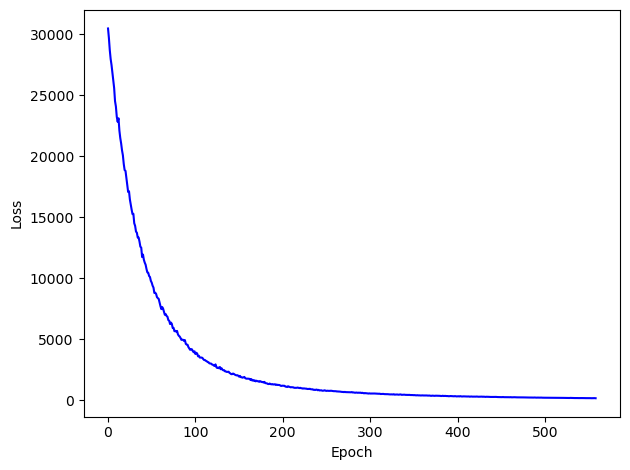

In [14]:
train_indices = np.arange(len(train_losses))
fig = plt.figure()
plt.plot(train_indices, train_losses, c='blue')
plt.ylabel('Loss')
plt.xlabel('Epoch')

fig.tight_layout()

/tmp/ipykernel_622507/1707345422.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_edge['IRT1_ability'] = ability.ravel()


Difficulty: PearsonRResult(statistic=-0.021113815036495596, pvalue=0.10415116306668877)
Age-Ability: PearsonRResult(statistic=0.8752909836177908, pvalue=0.0)
Ability: PearsonRResult(statistic=0.1824839771148017, pvalue=0.0)


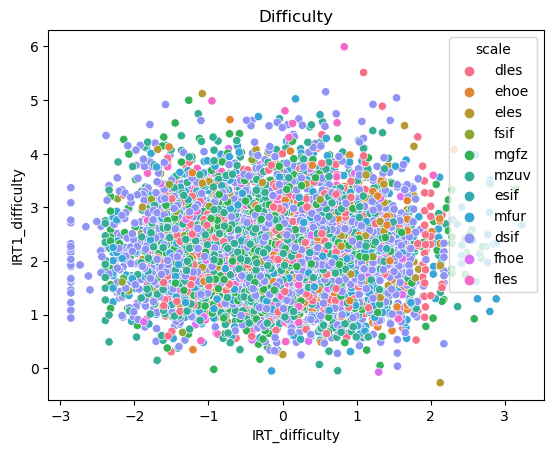

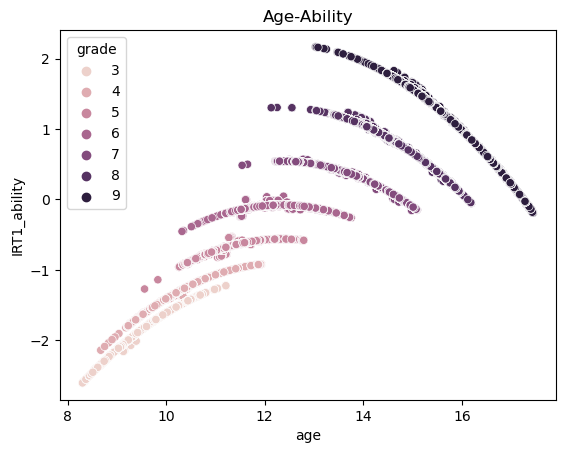

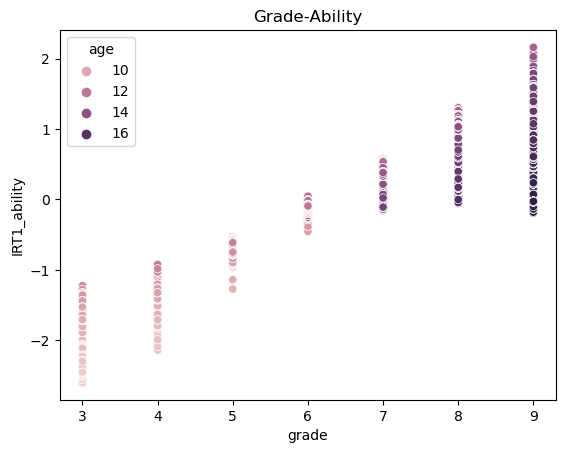

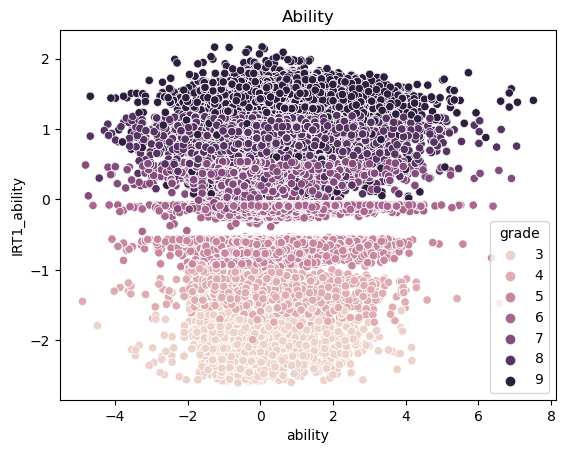

In [18]:
# save IRT parameters to matrix
if OUTNAME == 'IRT' and IRT_DIMS == 1:    
    #z_dict = model.get_embeddings(train_data.to(device))
    z_dict = output_dict['embedding_0']
    df_item['IRT1_difficulty'] = -z_dict['item']
    df_item['IRT1_discrimination'] = z_dict['offset']
    ability = z_dict['ability']
    df_edge['IRT1_ability'] = ability.ravel()
    
    aux_data = (df, df_student, df_item, df_edge, 
    train_losses, 
    train_edge_indices, val_edge_indices, test_edge_indices,
    data, train_data, val_data, test_data,
    unique_scales, unique_domains, unique_matdiff, 
    DATA_FILE)

    with open(f'./results/{OUTNAME}_aux_data_IRT1.pkl', 'wb') as handle:
        pickle.dump(aux_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    df_item_clean = df_item.dropna(subset=['IRT_difficulty', 'IRT1_difficulty'])    
    
    fig = plt.figure()
    sns.scatterplot(x='IRT_difficulty', y='IRT1_difficulty', data=df_item, hue='scale')
    plt.title('Difficulty')
    print('Difficulty:', pearsonr(df_item_clean['IRT1_difficulty'], df_item_clean['IRT_difficulty']))
    
    edge_feat = train_data['student', 'responds', 'item'].edge_attr.detach().cpu().numpy()
    df_edge_clean = df_edge.dropna(subset=['IRT1_ability', 'ability', 'age'])
    fig = plt.figure()
    sns.scatterplot(x='age', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Age-Ability')
    
    fig = plt.figure()
    sns.scatterplot(x='grade', y='IRT1_ability', data=df_edge_clean, hue='age')
    plt.title('Grade-Ability')
    print('Age-Ability:', pearsonr(df_edge_clean['age'], df_edge_clean['IRT1_ability']))

    fig = plt.figure()
    sns.scatterplot(x='ability', y='IRT1_ability', data=df_edge_clean, hue='grade')
    plt.title('Ability')
    print('Ability:', pearsonr(df_edge_clean['ability'], df_edge_clean['IRT1_ability']))
    